In [1]:
import pandas as pd
import numpy as np
from haversine import haversine, haversine_vector, Unit
import geopandas as gpd
import matplotlib.pyplot as plt
import cma

In [195]:
# read in the prepared dataset. Evaluate point data to make it readible by geopandas
df = pd.read_csv('data/test_dataset.csv', converters={'point': pd.eval})

In [196]:
# Filter to only one region, and read in geojson file.
region = 'Amhara' # Test Amhara region
woreda = 'ET030908'
proposed_schools= 5

### Region Only

In [197]:
# # limit geojson to only selected region
# # limit clean dataset to only selected region
# gdf_region = gpd.read_file('eth_shape_files/json//eth_admin1v2.json') # read in geojson
# gdf_region_shp = gdf_region.loc[gdf_region['ADM1_EN']==region]['geometry'].reset_index(drop=True)
# df = df.loc[df['region'] == region]
# bounds = gdf_region_shp.bounds

### Woreda Only

In [198]:
gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
df = df.loc[df['ADM3_PCODE'] == woreda]
bounds = gdf_woreda_shp.bounds
bounds

,minx,miny,maxx,maxy
0,36.689328,10.713719,36.96973,10.964773


In [199]:
# Establish boundaries for CMA
# Latitude is the Y axis, longitude is the X axis.
# bounds = gdf_region_shp.bounds
lat_bounds = bounds[['miny','maxy']].to_numpy()[0]
lon_bounds = bounds[['minx','maxx']].to_numpy()[0]
bounds = np.array([[lat_bounds[0], lon_bounds[0]], [lat_bounds[1], lon_bounds[1]]])
bounds # array - [[lower lat bounds, lower lon bounds],[upper lat bounds, upper lon bounds]]
# CMA expects a list of size 2 for bounds
x1y1 = np.repeat([bounds[0,:]],proposed_schools, axis=0).flatten()
x2y2 = np.repeat([bounds[1,:]],proposed_schools, axis=0).flatten()
boundsxy = [x1y1,x2y2]
boundsxy

[array([10.71371939, 36.68932805, 10.71371939, 36.68932805, 10.71371939,
        36.68932805, 10.71371939, 36.68932805, 10.71371939, 36.68932805]),
 array([10.96477258, 36.96973029, 10.96477258, 36.96973029, 10.96477258,
        36.96973029, 10.96477258, 36.96973029, 10.96477258, 36.96973029])]

In [200]:
# Create subset arrays required as input for enrollment function.
# 1. Primary school enrollment data
# 2. Primary school location data: lat lon point data. 
# 3. Secondary schoool location data: lat lon point data. 
# 4. Secondary school enrollment data. Potentially required for calibration function.

df_prim = df.loc[ (df['gr_offer'] == 'G.1-8') | (df['gr_offer'] == 'G.5-8')]
df_prim_enroll = df_prim['grade5_8'].reset_index(drop=True).to_numpy()
df_prim_loc = df_prim['point'].reset_index(drop=True).to_numpy()
df_prim_loc = np.array([np.array(i) for i in df_prim_loc])

df_sec = df.loc[ (df['gr_offer'] == 'G. 9-10') | (df['gr_offer'] == 'G. 9-12')]
df_sec_loc = df_sec['point'].reset_index(drop=True).to_numpy()
df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy()
df_sec_loc = np.array([np.array(i) for i in df_sec_loc])

In [201]:
def shape(distance, enrollment):
    min_walk = 2 # distance not a factor issuing enrollment until 2km
    max_walk = 5 # distance greater than 5km assumes zero enrollment
    return np.rint(np.where(distance<min_walk, enrollment,
             np.where(distance>max_walk, 0.00001,
                     enrollment*(1-(distance-min_walk)/(max_walk-min_walk)))
            ))

In [202]:
# shape function not included.
        def expected_enroll(prim_loc, x, prim_enroll, sec_loc):
            x = np.append(sec_loc, x) # The genotype
            x = np.array(np.array_split(x, (len(sec_loc)+proposed_schools)))
            distance = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True)
            min_d = np.min(distance, axis=0) # array with minimum distance from each primacy school to every secondary.
            return np.sum(min_d*prim_enroll)

In [654]:
# Shape Function included
def expected_enroll2(prim_loc, x, prim_enroll, sec_loc):
    if check_woreda(x):
        x = np.append(sec_loc, x) # The existing secondary (sec_loc) added to proposed secondary(x) i.e. the genotype
        x = np.array(np.array_split(x, (len(sec_loc)+proposed_schools))) # reshape for haversine fn (2,7)
        distance = haversine_vector(x,prim_loc, Unit.KILOMETERS, comb=True) # calculate distance - result= shape (21,7)
#         print(distance.shape)
        min_d = np.min(distance, axis=1) # shape (21,)
#         print(min_d.shape)
        shaped_enroll = shape(min_d, (prim_enroll*0.79901)) # shape(21,)
        return np.sum(shaped_enroll)
    else:
        return 0.01

In [655]:
bb1 = get_random_sp()
bb2 = np.array(np.array_split(bb1, 5))

In [656]:
expected_enroll2(df_prim_loc, bb2, df_prim_enroll, df_sec_loc)

24158.0

In [657]:
expected_enroll(df_prim_loc, bb2, df_prim_enroll, df_sec_loc)

111176.07755623708

In [658]:
f(bb1)

111176.07755623708

In [659]:
# The Objective Function
def f(x):
    """ The objective function which takes as input a 1d array.Every two elements 
    represent the lat/lon of a point in a given area. A locations variable is created
    which splits the points into pairs. The expected_enrollment function is then run 
    on this (5,2) list to return the total expected enrollment for the five locations.
    """
    locations = np.array(np.array_split(x, proposed_schools))
    test_case = expected_enroll(df_prim_loc, locations, df_prim_enroll, df_sec_loc)
#     return test_case # for expect_enroll
    return test_case*-1 # for expect_enroll2

In [660]:
def check_woreda(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_woreda_shp[0]).all()
            
def check_region(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_region_shp[0]).all()

In [661]:
# Create starting points within regional box boundaries.

def create_random_sp():
    sp1 = np.random.uniform(low=lat_bounds[0], high=lat_bounds[1], size=proposed_schools)
    sp2 = np.random.uniform(low=lon_bounds[0], high=lon_bounds[1], size=proposed_schools)
    sp = np.vstack((sp1, sp2)).T
    return sp

# create a random starting point within the target region.
def get_random_sp():
    sp = create_random_sp()
    for i in range(0,10000):
        if check_woreda(sp) == True:
            sp = sp.flatten()
            return sp
            break
        else:
            sp = create_random_sp()

In [662]:
# sigma should be 1/4th of the search domain width?
sigma= np.min(bounds, axis=1)
sigma= np.max(sigma) - np.min(sigma)
sigma = round(sigma / 4, 4)

In [663]:
maxits=  1000
# starting_point = np.array([[10.7875, 36.934],[10.79, 36.940]]).flatten()
es = cma.CMAEvolutionStrategy(get_random_sp(), sigma0=0.2,
                          inopts={'bounds': boundsxy,'seed':1234})
es.optimize(f, iterations=maxits / es.popsize, min_iterations=500)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Wed Jun 29 10:46:16 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -3.217520355564932e+05 1.0e+00 1.95e-01  2e-01  2e-01 0:00.0
    2     20 -3.289757456497230e+05 1.2e+00 1.85e-01  2e-01  2e-01 0:00.0
    3     30 -3.283749793032856e+05 1.2e+00 1.73e-01  2e-01  2e-01 0:00.0
   53    530 -3.358510374912745e+05 3.3e+00 5.33e-02  3e-02  6e-02 0:00.2
   54    540 -3.358510374912745e+05 3.3e+00 5.64e-02  3e-02  6e-02 0:00.2
   63    630 -3.358510374912745e+05 3.4e+00 4.10e-02  2e-02  5e-02 0:00.2
   64    640 -3.358510374912745e+05 3.4e+00 3.99e-02  2e-02  5e-02 0:00.2
   65    650 -3.358510374912745e+05 3.5e+00 3.87e-02  2e-02  4e-02 0:00.2
   66    660 -3.358510374912745e+05 3.5e+00 3.66e-02  2e-02  4e-02 0:00.2
   67    670 -3.358510374912745e+05 3.7e+00 3.58e-02  2e-02  4e-02 0:00.3
   68    680 -3.358510374912745e+05 3.7e+00 3.31e-02  2e-02  4e-02 0:00.3
   69    690 -3.35851037

  278   2780 -3.358510374912745e+05 2.0e+01 1.29e-02  4e-03  1e-02 0:01.1
  279   2790 -3.358510374912745e+05 1.9e+01 1.22e-02  3e-03  1e-02 0:01.1
  280   2800 -3.358510374912745e+05 1.8e+01 1.17e-02  3e-03  1e-02 0:01.1
  281   2810 -3.358510374912745e+05 1.8e+01 1.16e-02  3e-03  1e-02 0:01.1
  282   2820 -3.358510374912745e+05 1.8e+01 1.15e-02  3e-03  1e-02 0:01.1
  283   2830 -3.358510374912745e+05 1.8e+01 1.14e-02  3e-03  1e-02 0:01.1
  284   2840 -3.358510374912745e+05 1.9e+01 1.04e-02  3e-03  1e-02 0:01.1
  285   2850 -3.358510374912745e+05 1.9e+01 9.70e-03  3e-03  1e-02 0:01.1
  286   2860 -3.358510374912745e+05 1.9e+01 9.58e-03  3e-03  1e-02 0:01.1
  287   2870 -3.358510374912745e+05 1.9e+01 9.91e-03  3e-03  1e-02 0:01.2
  288   2880 -3.358510374912745e+05 1.8e+01 8.97e-03  2e-03  9e-03 0:01.2
  289   2890 -3.358510374912745e+05 1.7e+01 8.74e-03  2e-03  8e-03 0:01.2
  290   2900 -3.358510374912745e+05 1.7e+01 8.52e-03  2e-03  8e-03 0:01.2
  291   2910 -3.358510374912745e+05 1.

  389   3890 -3.358510374912745e+05 2.5e+01 6.49e-03  2e-03  5e-03 0:01.5
  390   3900 -3.358510374912745e+05 2.5e+01 6.42e-03  2e-03  5e-03 0:01.5
  391   3910 -3.358510374912745e+05 2.5e+01 6.47e-03  2e-03  5e-03 0:01.5
  392   3920 -3.358510374912745e+05 2.5e+01 6.36e-03  2e-03  5e-03 0:01.5
  393   3930 -3.358510374912745e+05 2.6e+01 6.16e-03  2e-03  5e-03 0:01.5
  394   3940 -3.358510374912745e+05 2.6e+01 5.51e-03  1e-03  5e-03 0:01.6
  395   3950 -3.358510374912745e+05 2.6e+01 5.13e-03  1e-03  4e-03 0:01.6
  396   3960 -3.358510374912745e+05 2.5e+01 5.41e-03  1e-03  4e-03 0:01.6
  397   3970 -3.358510374912745e+05 2.6e+01 5.17e-03  1e-03  4e-03 0:01.6
  398   3980 -3.358510374912745e+05 2.6e+01 5.19e-03  1e-03  4e-03 0:01.6
  399   3990 -3.358510374912745e+05 2.4e+01 5.26e-03  1e-03  4e-03 0:01.6
  400   4000 -3.358510374912745e+05 2.6e+01 5.41e-03  1e-03  4e-03 0:01.6
  401   4010 -3.358510374912745e+05 2.6e+01 5.06e-03  1e-03  4e-03 0:01.6
  402   4020 -3.358510374912745e+05 2.

In [664]:
best_solution = np.array(np.array_split(es.result[0].flatten(), proposed_schools))
best_solution

array([[10.93683072, 36.93129315],
       [10.91527621, 36.96610946],
       [10.96477258, 36.74327735],
       [10.96300963, 36.69430712],
       [10.95832478, 36.96924542]])

In [665]:
es.result[1]

-335851.03749127453

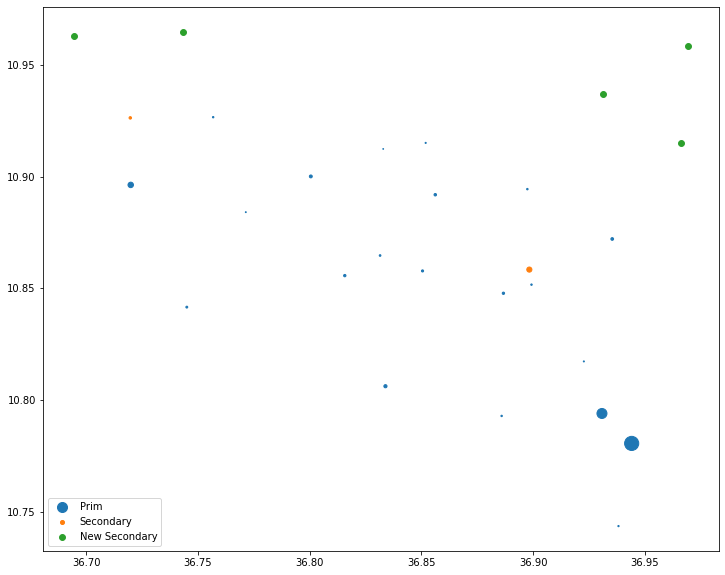

In [666]:
# it is latitude then longitude.
# box = np.array([[10.713719, 36.689328], [10.713719, 36.96973],[10.964773, 36.96973], [10.964773, 36.689328], [10.713719, 36.689328]])
plt.figure(figsize=(15, 10))
# plt.plot(box[:,1], box[:,0], '.r-')
plt.scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
plt.scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
plt.scatter(best_solution[:, 1], best_solution[:, 0], s = 35, marker="o", label="New Secondary") # stars for supermarkets
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

In [667]:
es.result[1]

-335851.03749127453